In [1]:
%load_ext autoreload
%autoreload 2


In [2]:


import torch 
import matplotlib.pyplot as plt
import numpy as np
import random
import json
def set_seed(seed=0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch. cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import re
from predictive_learning.utils.config_utils import *
from collections import defaultdict
import omegaconf
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plot_seeds_mean(ax,x,accuracies, label,color,linestyle='-'):
    means = np.mean(accuracies, axis=0)
    stds = np.std(accuracies, axis=0)
    ax.plot(x,means, label=label, color=color,linestyle=linestyle)
    ax.fill_between(x, means-stds, means+stds,
            alpha=0.2, edgecolor=color, facecolor=color)

def savefig(fig,path):
    fig.savefig(f"{path}.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(f"{path}.png", bbox_inches='tight', dpi=300)
    print(f'Saved figure to {path}')
    
    
    

In [ ]:
COLORS = ["#264653", '#2a9d8f', '#ffb703']

In [4]:
def concat_seeds(results,mean_position=True):
    grouped_results = collections.defaultdict(list)
    for params, path,data in results:
        params_without_seed = frozenset((k, v) for k, v in params.items() if k != "seed" and k!= "dir")
        grouped_results[params_without_seed].append((params,data,path))
    
    grouped_keys = list(grouped_results.keys())
    for k in grouped_keys:
        if len(grouped_results[k]) <= 1:
            grouped_results.pop(k)
    grouped_concatenated_results = []
    for gres in grouped_results.values():
        data = {}
        if len(gres) < 2:
            continue 
        for res in gres:
            for key in res[1].keys():
                if key not in data:
                    data[key] = []
                data[key].append(res[1][key])
                
        data = {key: np.stack(val,axis=0) for key,val in data.items()}
        path = gres[0][2]
        hparams = gres[0][0] 
        grouped_concatenated_results.append((hparams,path,data))
    return grouped_concatenated_results


In [5]:
from omegaconf import DictConfig, ListConfig
def omegaconf_to_builtin(obj):
    """
    Recursively converts DictConfig to dict and ListConfig to list.
    """
    if isinstance(obj, DictConfig):
        return {k: omegaconf_to_builtin(v) for k, v in obj.items()}
    elif isinstance(obj, ListConfig):
        return [omegaconf_to_builtin(v) for v in obj]
    elif isinstance(obj, dict):
        return {k: omegaconf_to_builtin(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [omegaconf_to_builtin(v) for v in obj]
    else:
        return obj


In [6]:
def get_best_results_for_curve(results,
                               metric,
                               min_or_max="max",
                              num_expected_seeds=2):
    
    all_res_for_metric = np.array([res[2][metric][:num_expected_seeds] for res in results if res[2][metric].shape[0] >= num_expected_seeds])
    results_with_enough_seeds = [res for res in results if res[2][metric].shape[0] >= num_expected_seeds]

    if len(results_with_enough_seeds) == 0:
        return None
    if min_or_max == "max":
        best_res_idx = np.argmax(all_res_for_metric.mean((1))[:,-1],axis=0)
    else:
        best_res_idx = np.argmin(all_res_for_metric.mean((1))[:,-1],axis=0)
    best_res = results_with_enough_seeds[best_res_idx]
    return best_res
    

In [7]:



def make_disentanglement_metrics_product(results):
    
    for res in results:
        res[2]["disentanglement_product"] = res[2]["primitive_val_classifier_gener"] * res[2]["color_val_classifier_gener"] * res[2]["position_val_classifier_gener"]



In [8]:
import os
import collections
import numpy as np
from omegaconf import OmegaConf
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import defaultdict

def flatten(dictionary, parent_key=False, separator='.'):
    """
    Turn a nested dictionary into a flattened dictionary
    :param dictionary: The dictionary to flatten
    :param parent_key: The string to prepend to dictionary's keys
    :param separator: The string used to separate flattened keys
    :return: A flattened dictionary
    """
    items = []
    for key, value in dictionary.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else str(key)
        if isinstance(value, collections.abc.MutableMapping):
            items.extend(flatten(value, new_key, separator).items())
        else:
            items.append((new_key, value))
    return dict(items)


def _process_folder(root, params):
    """Helper to check a single folder's config against params."""
    config_path = os.path.join(root, '.hydra', 'config.yaml')
    results_path = os.path.join(root, 'results.npz')
    if not (os.path.isfile(config_path) and os.path.isfile(results_path)):
        return None

    saved_config = OmegaConf.load(config_path)
    flat_args = flatten(saved_config)

    # Compare parameters
    for key, val in params.items():
        if key not in flat_args:
            # skip default/false/zero flags
            if isinstance(val, bool) and not val:
                continue
            if isinstance(val, float) and val == 0.0:
                continue
            return None
        if flat_args[key] != val:
            return None

    return flat_args, root


def get_results_for_hyperparams(params, parents_dir, n_jobs=-1, verbose=True):
    """
    Search through parents_dir for runs matching params (dict), then load their results.
    Parallelizes the config-matching step and loads .npz files after.

    :param params: dict of flattened keys to match
    :param parents_dir: root directory containing run folders
    :param n_jobs: number of parallel jobs (default: all cores)
    :param verbose: whether to print summary
    :return: list of tuples (args_dict, folder_path, npz_data)
    """
    # Gather all candidate roots
    candidate_roots = []
    for root, dirs, files in os.walk(parents_dir):
        if '.hydra' in dirs and 'results.npz' in files:
            candidate_roots.append(root)

    total = len(candidate_roots)
    # Process config checks in parallel
    processed = Parallel(n_jobs=n_jobs)(
        delayed(_process_folder)(root, params)
        for root in candidate_roots
    )
    # Filter out non-matches
    matches = [res for res in processed if res is not None]

    # Load .npz data serially (avoiding unpickleable file handles in workers)
    results = []
    for flat_args, root in matches:
        data = np.load(os.path.join(root, 'results.npz'), allow_pickle=True)
        results.append((flat_args, root, data))

    if verbose:
        print(f"Total possible results: {total}")
        print(f"Total results found: {len(results)}")
    return results


def group_results_by_params(param_names, base_hparams, parents_dir, n_jobs=-1):
    """
    Group collected runs by up to two hyperparameter names.
    :param param_names: list of 1 or 2 keys in flattened config to group by
    :param base_hparams: dict of other fixed hyperparams
    :param parents_dir: root directory of runs
    :param n_jobs: unused here, placeholder for API consistency
    :return: dict mapping param-value or param-value tuple to list of (flat_args, folder, data)
    """
    runs = get_results_for_hyperparams(base_hparams, parents_dir,n_jobs=n_jobs)
    groups = defaultdict(list)
    for flat_args, folder, data in runs:
        if len(param_names) == 1:
            if isinstance(flat_args[param_names[0]],omegaconf.listconfig.ListConfig):
                key = tuple(OmegaConf.to_container(flat_args[param_names[0]]))
            else:
                key = flat_args[param_names[0]]
            
        else:
            key = []
            for name in param_names:
                if isinstance(flat_args[name],omegaconf.listconfig.ListConfig):
                    key.append(tuple(OmegaConf.to_container(flat_args[name])))
                else:
                    key.append(flat_args[name])
            key = tuple(key)
        groups[key].append((flat_args, folder, data))
    return dict(groups)




In [9]:
def plot_best_curves(groups,
                     curve_names,
                     metric_key,
                     min_or_max="min",
                     xlabel="Epoch",
                     ylabel="Value",
                     num_expected_seeds=2,
                     n_jobs=-1):
    """
    Compute and plot best curves for each group and each metric in curve_names, in parallel.
    First hyperparameter groups get distinct base colors; second hyperparameter variations are lighter shades.
    :param groups: dict from group key to list of (flat_args, folder, data)
    :param curve_names: list of metric names to extract via get_best_results_for_curve
    :param metric_key: key passed into get_best_results_for_curve
    :param min_or_max: "min" or "max"
    :param xlabel: x-axis label
    :param ylabel: y-axis label
    :param n_jobs: parallel jobs for computing best curves
    """

    is_2d = all(len(k) == 2 for k in groups)

    if is_2d:
        p1_vals = sorted({k[0] for k in groups})
        cmap = plt.get_cmap('tab10')
        base_colors = {p1: cmap(i % 10) for i, p1 in enumerate(p1_vals)}
        p2_map = {p1: sorted({k[1] for k in groups if k[0] == p1}) for p1 in p1_vals}
    else:
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    def _compute_best(group_val, runs, metric):
        concats = concat_seeds(runs)
        make_disentanglement_metrics_product(concats)
        best = get_best_results_for_curve(concats, 
                                          metric_key,
                                          min_or_max=min_or_max,
                                          num_expected_seeds=num_expected_seeds)
        if best is None:
            print(f"Group {group_val} has no runs with at least {num_expected_seeds} seeds for metric {metric_key}.")
            return None,None,None
        return group_val, best[2][metric],best

    best_results_per_curve = {}
    for curve_name in curve_names:

        all_runs = [(gv, runs, curve_name) for gv, runs in groups.items()]
        results = [_compute_best(gv, runs, cn) for gv, runs, cn in all_runs]
        results = [res for res in results if res[0] is not None]
        # plotting
        fig, ax = plt.subplots(figsize=(8,5))
        for group_val, curve,resu in sorted(results, key=lambda x: x[0]):
            best_results_per_curve[group_val] = resu
            epochs = np.arange(curve.shape[1])
            if is_2d:
                p1, p2 = group_val
                base = base_colors[p1]
                p2_list = p2_map[p1]
                idx = p2_list.index(p2)
                # shade factor [0..1]
                factor = idx / max(len(p2_list)-1, 1)
                # lighten towards white
                shade = tuple(c + (1-c)*0.5*factor for c in base)
                color = shade
                label = f"{p1},{p2}"
            else:
                idx = list(groups).index(group_val)
                color = color_cycle[idx % len(color_cycle)]
                label = str(group_val)
                
            print(group_val,curve.shape)
            plot_seeds_mean(ax, epochs, curve, label, color)

        ax.set_title(f"Best {curve_name}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(title="Group")
        plt.tight_layout()
        plt.show()
    return best_results_per_curve


In [10]:
groups = group_results_by_params(
    param_names   = ["model.type"],
    base_hparams  = {},
    parents_dir   = "/home/ghb24/paper_git/comp_predictive_learning/revieww/"
)

Total possible results: 464
Total results found: 464


auto (2, 21)
mem (2, 21)
pred (2, 21)


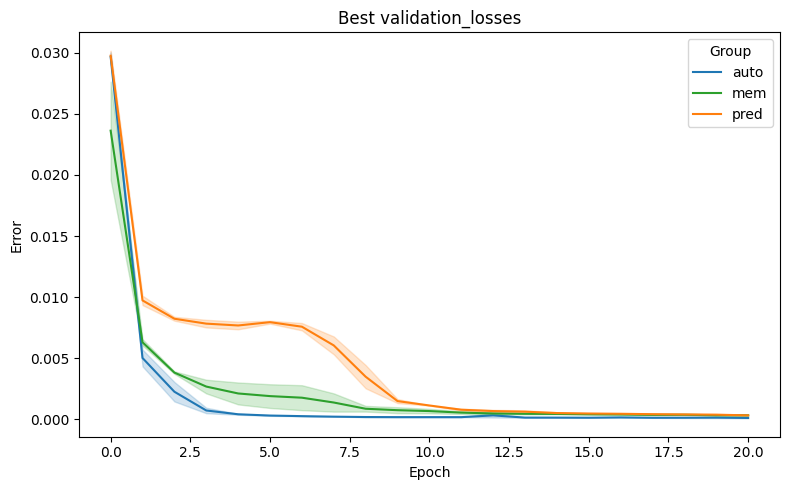

auto (2, 21)
mem (2, 21)
pred (2, 21)


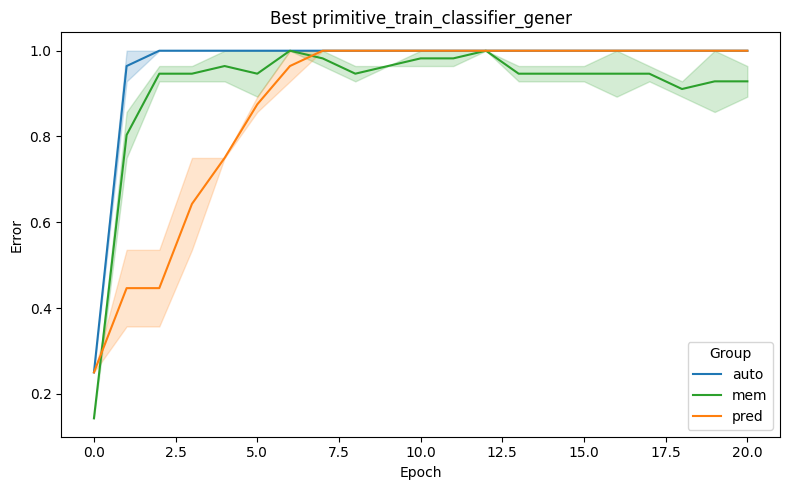

auto (2, 21)
mem (2, 21)
pred (2, 21)


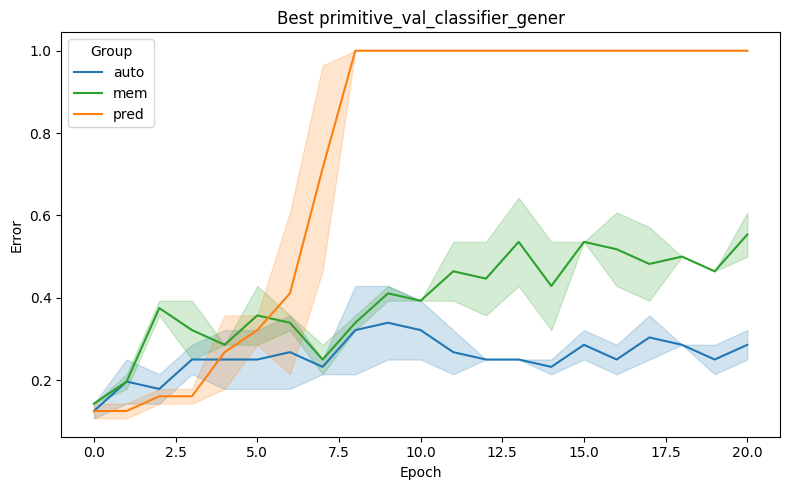

auto (2, 21)
mem (2, 21)
pred (2, 21)


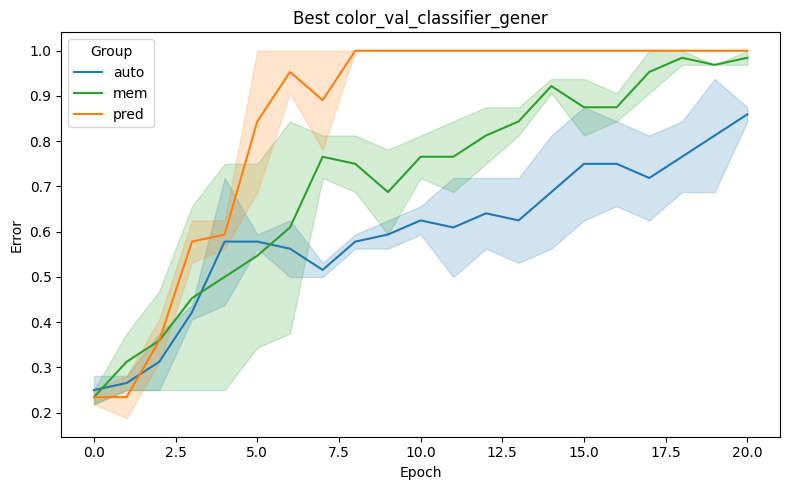

auto (2, 21)
mem (2, 21)
pred (2, 21)


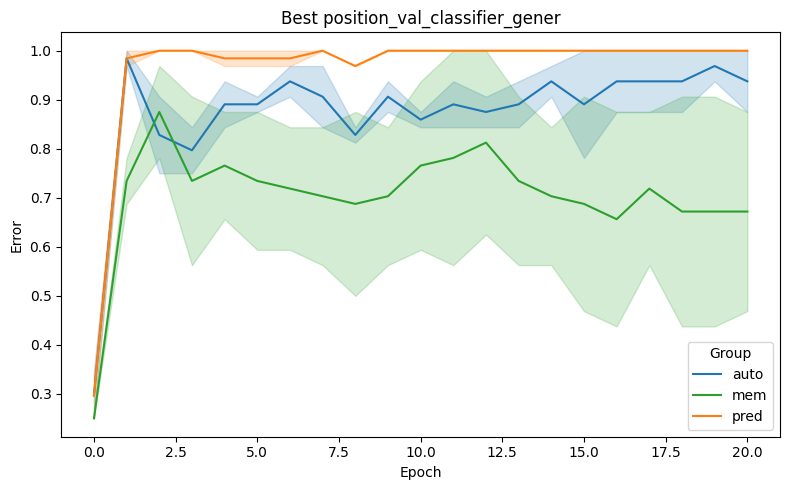

auto (2, 21)
mem (2, 21)
pred (2, 21)


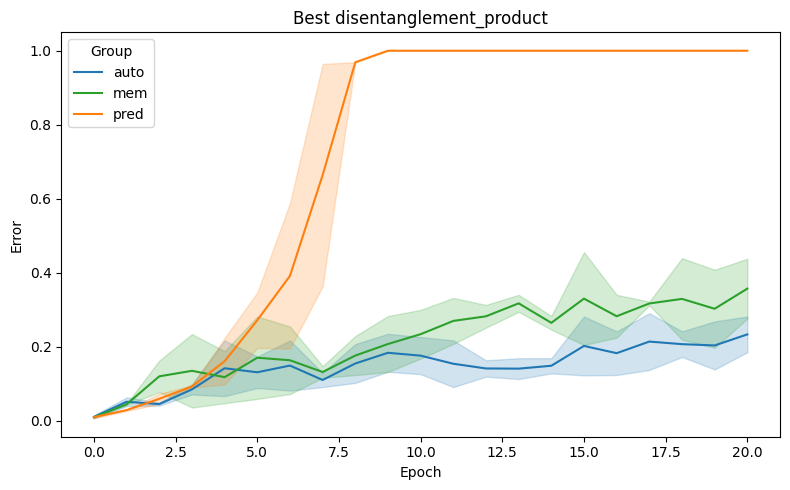

In [20]:
best_res = plot_best_curves(
    groups       = groups,
    curve_names  = [
                   "validation_losses",
                   "primitive_train_classifier_gener",
                    "primitive_val_classifier_gener",
                    "color_val_classifier_gener",
                    "position_val_classifier_gener",
                    "disentanglement_product"],
    metric_key   = "disentanglement_product",
    min_or_max   = "max",
    xlabel       = "Epoch",
    ylabel       = "Error",
    num_expected_seeds=2
)


In [21]:
best_res_pred = best_res[('pred')]
best_res_auto = best_res[('auto')]

In [22]:
best_res_auto

({'model._target_': 'compo_predictive_learning.models.rnn_ae.RNNAE',
  'model.encoder_cfg': None,
  'model.decoder_cfg': None,
  'model.rnn_cfg': None,
  'model.type': 'auto',
  'model.name': 'ae_auto',
  'dataset.num_pretrain_drawings_per_context': 512,
  'dataset.num_val_drawings_per_context': 128,
  'dataset.num_test_drawings_per_context': 128,
  'dataset.colorize_white': False,
  'dataset.canvas_size': 64,
  'dataset.unit_length': 16,
  'dataset.premake_videos': False,
  'dataset.scales': [1],
  'dataset.colors': ['white', 'red', 'green', 'blue'],
  'dataset.symbol_timestep': 0,
  'dataset.sequence_length': 6,
  'dataset.noisy_in_quadrant_locations': False,
  'dataset.contexts': ['next_primitive_offset', 'next_color_offset', 'next_position_offset', 'next_scale_offset'],
  'dataset.next_primitive_offset': [0, 1, 2, 3, 4, 5],
  'dataset.next_scale_offset': [0],
  'dataset.next_color_offset': [0, 1, 2],
  'dataset.next_position_offset': [0, 1, 2],
  'dataset.name': "sketch_6/['white',

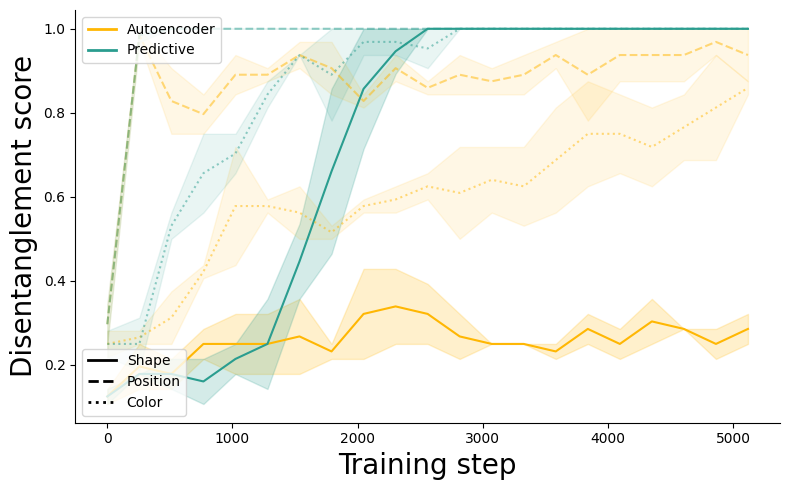

In [17]:
def plot_seeds_mean(ax,x,accuracies, label,color,linestyle='-',alpha=1.0):
    means = np.mean(accuracies, axis=0)
    stds = np.std(accuracies, axis=0)
    ax.plot(x,means, label=label, color=color,linestyle=linestyle,alpha=alpha)
    ax.fill_between(x, means-stds, means+stds,
            alpha=0.2*alpha, edgecolor=color, facecolor=color)

latent_types = [
    ("primitive_val_classifier_gener", "Shape", "-"),
    ("position_val_classifier_gener", "Position", "--"),
    ("color_val_classifier_gener", "Color", ":"),
]

# Two colors for models
model_colors = {
    "Autoencoder": COLORS[2],
    "Predictive":COLORS[1],
}
steps = np.arange(best_res_auto[2]["validation_losses"].shape[1])*best_res_pred[0]["train_loop.eval_every"]


fig, ax = plt.subplots(figsize=(8,5))

for key, latent_label, ls in latent_types:
    # Autoencoder
    alpha = 1 if latent_label == "Shape" else 0.5
    plot_seeds_mean(ax, steps, best_res_auto[2][key],
                    f"{latent_label} - Autoencoder",
                    model_colors["Autoencoder"], linestyle=ls,alpha=alpha)
    # Predictive
    plot_seeds_mean(ax, steps, best_res_pred[2][key],
                    f"{latent_label} - Predictive",
                    model_colors["Predictive"], linestyle=ls,alpha=alpha)

ax.set_xlabel("Training step", fontsize=20)
ax.set_ylabel("Disentanglement score", fontsize=20)
# ax.set_title("Disentanglement of the latents through training", fontsize=16)

from matplotlib.lines import Line2D
# Legend for latent types
latent_legend = [
    Line2D([0], [0], color="black", lw=2, linestyle=ls, label=label)
    for _, label, ls in latent_types
]
# Legend for models
model_legend = [
    Line2D([0], [0], color=c, lw=2, label=model)
    for model, c in model_colors.items()
]

# Place legends in opposite corners, no title
legend1 = ax.legend(handles=model_legend, loc="upper left", frameon=True)
legend2 = ax.legend(handles=latent_legend, loc="lower left", frameon=True)
ax.add_artist(legend1)  # Keep first legend when adding second

# Remove top and right spines (only x and y axes remain)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
fig.savefig("figures/disentanglement_latents.pdf", bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
def plot_seeds_mean(ax,x,accuracies, label,color,linestyle='-',alpha=1.0):
    means = np.mean(accuracies, axis=0)
    stds = np.std(accuracies, axis=0)
    ax.plot(x,means, label=label, color=color,linestyle=linestyle,alpha=alpha)
    ax.fill_between(x, means-stds, means+stds,
            alpha=0.2*alpha, edgecolor=color, facecolor=color)

latent_types = [
    ("primitive_val_classifier_gener", "Shape", "-"),
    ("position_val_classifier_gener", "Position", "--"),
    ("color_val_classifier_gener", "Color", ":"),
]

# Two colors for models
model_colors = {
    "Autoencoder": COLORS[2],
    "Predictive":COLORS[1],
}
steps = np.arange(best_res_auto[2]["validation_losses"].shape[1])*best_res_pred[0]["train_loop.eval_every"]


fig, ax = plt.subplots(figsize=(8,5))

plot_seeds_mean(ax, steps, best_res_auto[2]["disentanglement_product"],
                f"Autoencoder",
                model_colors["Autoencoder"], linestyle=ls,alpha=alpha)
# Predictive
plot_seeds_mean(ax, steps, best_res_pred[2]["disentanglement_product"],
                f"Predictive",
                model_colors["Predictive"], linestyle=ls,alpha=alpha)

ax.set_xlabel("Training step", fontsize=20)
ax.set_ylabel("Disentanglement score", fontsize=20)
# ax.set_title("Disentanglement of the latents through training", fontsize=16)

from matplotlib.lines import Line2D
# Legend for latent types
latent_legend = [
    Line2D([0], [0], color="black", lw=2, linestyle=ls, label=label)
    for _, label, ls in latent_types
]
# Legend for models
model_legend = [
    Line2D([0], [0], color=c, lw=2, label=model)
    for model, c in model_colors.items()
]

# Place legends in opposite corners, no title
legend1 = ax.legend(handles=model_legend, loc="upper left", frameon=True)
legend2 = ax.legend(handles=latent_legend, loc="lower left", frameon=True)
ax.add_artist(legend1)  # Keep first legend when adding second

# Remove top and right spines (only x and y axes remain)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
fig.savefig("figures/disentanglement_latents.pdf", bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
latent_types = [
    ("training_losses", "Training", "-"),
    ("validation_losses", "Generalization", "--"),
]

# Two colors for models
model_colors = {
    "Autoencoder": COLORS[2],
    "Predictive":COLORS[1],
}
steps = np.arange(best_res_auto[2]["training_losses"].shape[1])*best_res_pred[0]["train_loop.eval_every"]


fig, ax = plt.subplots(figsize=(8,5))

for key, latent_label, ls in latent_types:
    # Autoencoder
    plot_seeds_mean(ax, steps, best_res_auto[2][key],
                    f"{latent_label} - Autoencoder",
                    model_colors["Autoencoder"], linestyle=ls)
    # Predictive
    plot_seeds_mean(ax, steps, best_res_pred[2][key],
                    f"{latent_label} - Predictive",
                    model_colors["Predictive"], linestyle=ls)

ax.set_xlabel("Training step",fontsize=15)
ax.set_ylabel("Loss",fontsize=15)
# ax.set_title("Train and validation losses")

from matplotlib.lines import Line2D
latent_legend = [
    Line2D([0], [0], color="black", lw=2, linestyle=ls, label=label)
    for _, label, ls in latent_types
]
model_legend = [
    Line2D([0], [0], color=c, lw=2, label=model)
    for model, c in model_colors.items()
]

legend1 = ax.legend(handles=model_legend, loc="upper left", frameon=True)
legend2 = ax.legend(handles=latent_legend, loc="upper right", frameon=True)
ax.add_artist(legend1)  
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
fig.savefig("figures/losses.pdf", bbox_inches='tight', dpi=300)

plt.show()


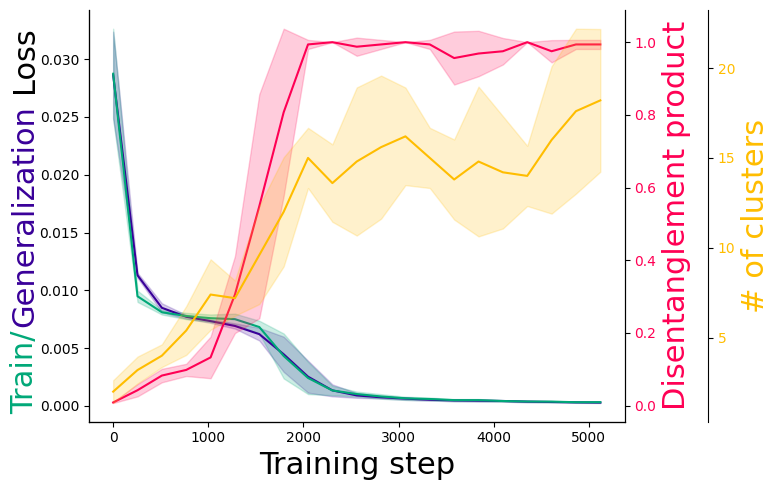

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Dummy function and data for reproducibility
def plot_seeds_mean(ax, steps, data, label, color):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    ax.plot(steps, mean, label=label, color=color)
    ax.fill_between(steps, mean - std, mean + std, alpha=0.2, color=color)
# Colors for the plot
PLOT_COLORS = ["#390099", "#FF0054", "#FFBD00", "#00A878"] # Purple, Pink, Yellow, Green
steps = np.arange(best_res_pred[2]["validation_losses"].shape[1]) * best_res_pred[0]["train_loop.eval_every"]

fig, ax1 = plt.subplots(figsize=(8, 5))

# First axis: validation and training loss
plot_seeds_mean(ax1, steps, best_res_pred[2]["training_losses"],
                "Training loss", color=PLOT_COLORS[0])

plot_seeds_mean(ax1, steps, best_res_pred[2]["validation_losses"],
                "Validation loss", color=PLOT_COLORS[3])

ax1.set_xlabel("Training step", fontsize=22)
ax1.tick_params(axis="y", labelcolor="black")

# --- CHANGE IS HERE ---
# Remove the old y-label and create a new multi-colored one
# ax1.set_ylabel("Train/Validation Loss", color="black", fontsize=22) # This line is removed
ax1.text(-0.12, 0.12, 'Train/', transform=ax1.transAxes, fontsize=22,
         color=PLOT_COLORS[3], va='center', ha='center', rotation='vertical')
ax1.text(-0.12, 0.5, 'Generalization', transform=ax1.transAxes, fontsize=22,
         color=PLOT_COLORS[0], va='center', ha='center', rotation='vertical')
ax1.text(-0.12, 0.88, 'Loss', transform=ax1.transAxes, fontsize=22,
         color="black", va='center', ha='center', rotation='vertical')

# --- END OF CHANGE ---

# Second axis: product of disentanglement metric
ax2 = ax1.twinx()
disentanglement_product = (
    best_res_pred[2]["primitive_val_classifier_gener"] *
    best_res_pred[2]["position_val_classifier_gener"] *
    best_res_pred[2]["color_val_classifier_gener"]
)
plot_seeds_mean(ax2, steps, disentanglement_product,
                "Product of disentanglement metric", color=PLOT_COLORS[1])
ax2.set_ylabel("Disentanglement product", color=PLOT_COLORS[1], fontsize=22)
ax2.tick_params(axis="y", labelcolor=PLOT_COLORS[1])

# Third axis: optimal clusters
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
plot_seeds_mean(ax3, steps, best_res_pred[2]["optimal_n_clusters"],
                "Optimal clusters", color=PLOT_COLORS[2])
ax3.set_ylabel("# of clusters", color=PLOT_COLORS[2], fontsize=22)
ax3.tick_params(axis="y", labelcolor=PLOT_COLORS[2])

# Styling
ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax3.spines["top"].set_visible(False)

fig.tight_layout()
fig.savefig("all_in_one.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_final_values_violin_colored(groups,
                                     curve_names,
                                     model_to_params, # <-- New argument
                                     success_metric='validation_losses',
                                     success_threshold=0.005,
                                     title_prefix="Final Value Distribution"):
    """
    Creates violin plots with points colored by a success criterion.
    This version also colors the violin bodies and sets custom x-axis labels
    based on the provided model_to_params dictionary.

    :param groups: A dict where keys are model identifiers (e.g., "pred", "auto") that
                   must match the keys in model_to_params. The values are the lists of runs.
    :param curve_names: List of metric names to plot.
    :param model_to_params: Dict mapping model identifiers to their color and pretty name.
    :param success_metric: The metric used to define success.
    :param success_threshold: A model is successful if its final metric is below this value.
    :param title_prefix: A prefix for the plot title.
    """
    xlabel = "Model Type"
    dot_palette = {"Successful": "lime", "Not Successful": "tomato"}
    # --- New: Create a palette for the violin bodies ---
    violin_palette = {key: val[0] for key, val in model_to_params.items()}

    for curve_name_idx, curve_name in enumerate(curve_names):
        plot_data = []
        # The data preparation loop remains IDENTICAL to the previous version
        for group_val, runs in groups.items():
            # 'group_val' here is now the model key, e.g., "pred"
            runs = [(r[0],r[1],dict(r[2])) for r in runs]
            make_disentanglement_metrics_product(runs)
            for run_args, run_path, run_data in runs:
                if curve_name in run_data:
                    final_value = run_data[curve_name][-1]
                    is_successful = False
                    if success_metric in run_data and run_data[success_metric][-1] < success_threshold:
                        is_successful = True
                    status = "Successful" if is_successful else "Not Successful"
                    plot_data.append({
                        xlabel: str(group_val),
                        'value': final_value,
                        'Status': status
                    })

        if not plot_data:
            print(f"Skipping plot for '{curve_name}' as no data was found.")
            continue
        
        df = pd.DataFrame(plot_data)
        
        fig, ax = plt.subplots(figsize=(10, 7))

        # --- Changes are only in this plotting section ---

        # 1. Draw violins, now colored using the new violin_palette
        sns.violinplot(
            data=df, 
            x=xlabel,
            y='value',
            ax=ax,
            hue="Model Type",
            inner=None,
            palette=violin_palette,            # <-- Use model colors
            order=list(model_to_params.keys()),# <-- Ensure consistent order
            alpha=0.8,
            cut=0
        )

        # 2. Overlay dots (unchanged logic, but add 'order' for alignment)
        sns.stripplot(
            data=df, x=xlabel, y='value', ax=ax, hue='Status', palette=dot_palette,
            jitter=True, dodge=True, size=6, alpha=0.5,
            order=list(model_to_params.keys()) # <-- Ensure alignment
        )
        
        # 3. Set the custom x-axis tick labels
        xtick_labels = [params[1] for params in model_to_params.values()]
        ax.set_xticklabels(xtick_labels, rotation=0, fontsize=22)

        if curve_name == "disentanglement_product":
            ax.set_title("Product of Disentanglement Scores", fontsize=32)
            ax.set_ylabel(f"Aggregate disentanglement score", fontsize=24)
        else:
            title_curve = curve_name.split('_')[0] if "primitive" not in curve_name else "shape"
            ax.set_title(f"Disentanglement of the {title_curve}", fontsize=32)
            ax.set_ylabel(f"Disentanglement score", fontsize=24)
            
        ax.set_xlabel(xlabel, fontsize=24)
        
        if curve_name_idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            # keep only the Status entries
            keep = [(h, l) for h, l in zip(handles, labels) if l in dot_palette]
            if keep:
                ax.legend(*zip(*keep), fontsize=16, title='Run Status', title_fontsize=18)
        else:
            # make sure no legend shows up on later plots
            leg = ax.get_legend()
            if leg is not None:
                leg.remove()

        plt.grid(True, linestyle='--', alpha=0.6, axis='y')
        plt.tight_layout()
        plt.savefig("figures/disent_violin_"+curve_name+".pdf")
        plt.show()
        

In [ ]:
model_to_params = {"pred": [COLORS[1],"Predictive"],
                    "auto": [COLORS[2],"RNN Autoencoder"],
                    "cnn_auto": [COLORS[0],"CNN Autoencoder"]}
plot_final_values_violin_colored(
    groups=groups,
    curve_names=['disentanglement_product', 'primitive_val_classifier_gener','position_val_classifier_gener','color_val_classifier_gener'],
    model_to_params=model_to_params # Pass the new mapping dictionary
)

